<a href="https://colab.research.google.com/github/Akage1234/nn-zero-to-hero/blob/main/MicroGrad/MicroGrad_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Derivatives, Gradients and Backprop - Introduction

In [83]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [84]:
def f(x):
    return 3*x**2 - 4*x + 5

f(3.0)

20.0

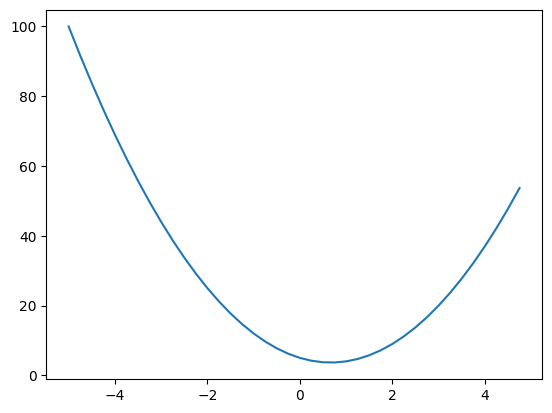

In [85]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [86]:
h = 0.00001
x = 2/3
(f(x+h) - f(x))/h

3.0000002482211127e-05

In [87]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a+=h
d2 = a*b + c
print("slope: ", (d2-d1)/h)

slope:  -3.000000000010772


In [88]:
import math
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0
        self._backward = lambda: None
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"(Value={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __pow__(self, other):
        assert isinstance(other, (int, float)) , "Only supports int, float for now"
        out = Value(self.data**other, (self, ), f"**{other}")
        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * other**-1

    def __radd__(self, other):
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh' )
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp' )
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [89]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(uid, label="%s | data %.4f | grad %.4f" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [90]:
# gradient checking
def lol():
    h = 0.0001
    a = Value(2.0, label='a')
    b = Value(5.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(2.0, label='f')
    L1 = d*f;L1.label = 'L'
    L1

    a = Value(2.0, label='a')
    b = Value(5.0 + h, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(2.0, label='f')
    L2 = d*f;L2.label = 'L'
    L2

    print((L2.data-L1.data)/h)

lol()

3.9999999999906777


### Neuron (Perceptron)

In [91]:

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1;x1w1.label='x1*w1'
x2w2 = x2*w2;x2w2.label='x2*w2'

x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# o = n.tanh(); o.label = 'o'
e = (2*n).exp()
o = (e-1)/(e+1)
o.label = 'o'

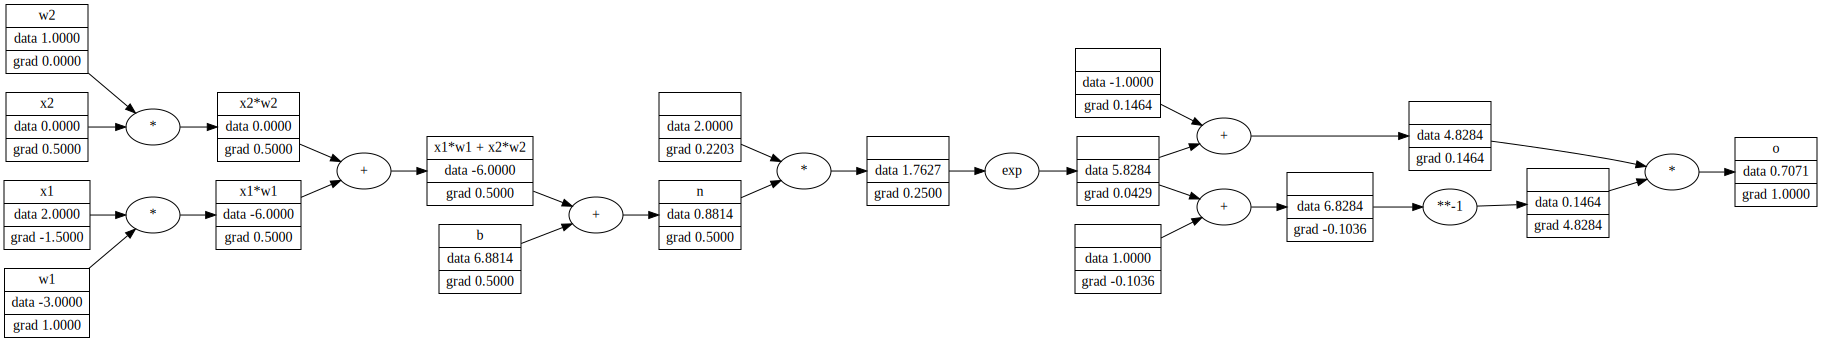

In [92]:
o.backward()
draw_dot(o)

In [93]:
# pytorch example to confirm results
import torch
x1 = torch.tensor([2.0]).double() ; x1.requires_grad=True
x2 = torch.tensor([0.0]).double() ; x2.requires_grad=True
w1 = torch.tensor([-3.0]).double() ; w1.requires_grad=True
w2 = torch.tensor([1.0]).double() ; w2.requires_grad=True
b = torch.tensor([6.8813735870195432]).double() ; b.requires_grad=True

In [94]:
n = x1*w1  + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()
print('-'*50)
print("x1: ",x1.grad.item())
print("w2: ",w2.grad.item())
print("x2: ",x2.grad.item())
print("w2: ",w2.grad.item())

0.7071066904050358
--------------------------------------------------
x1:  -1.5000003851533106
w2:  0.0
x2:  0.5000001283844369
w2:  0.0


### Creating MLP from scratch

In [95]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = (Value(random.uniform(-1, 1)))

    def __call__(self, x):
        # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layers in self.layers for p in layers.parameters()]

In [96]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

(Value=0.7466946719546488)

In [97]:
len(n.parameters())

41

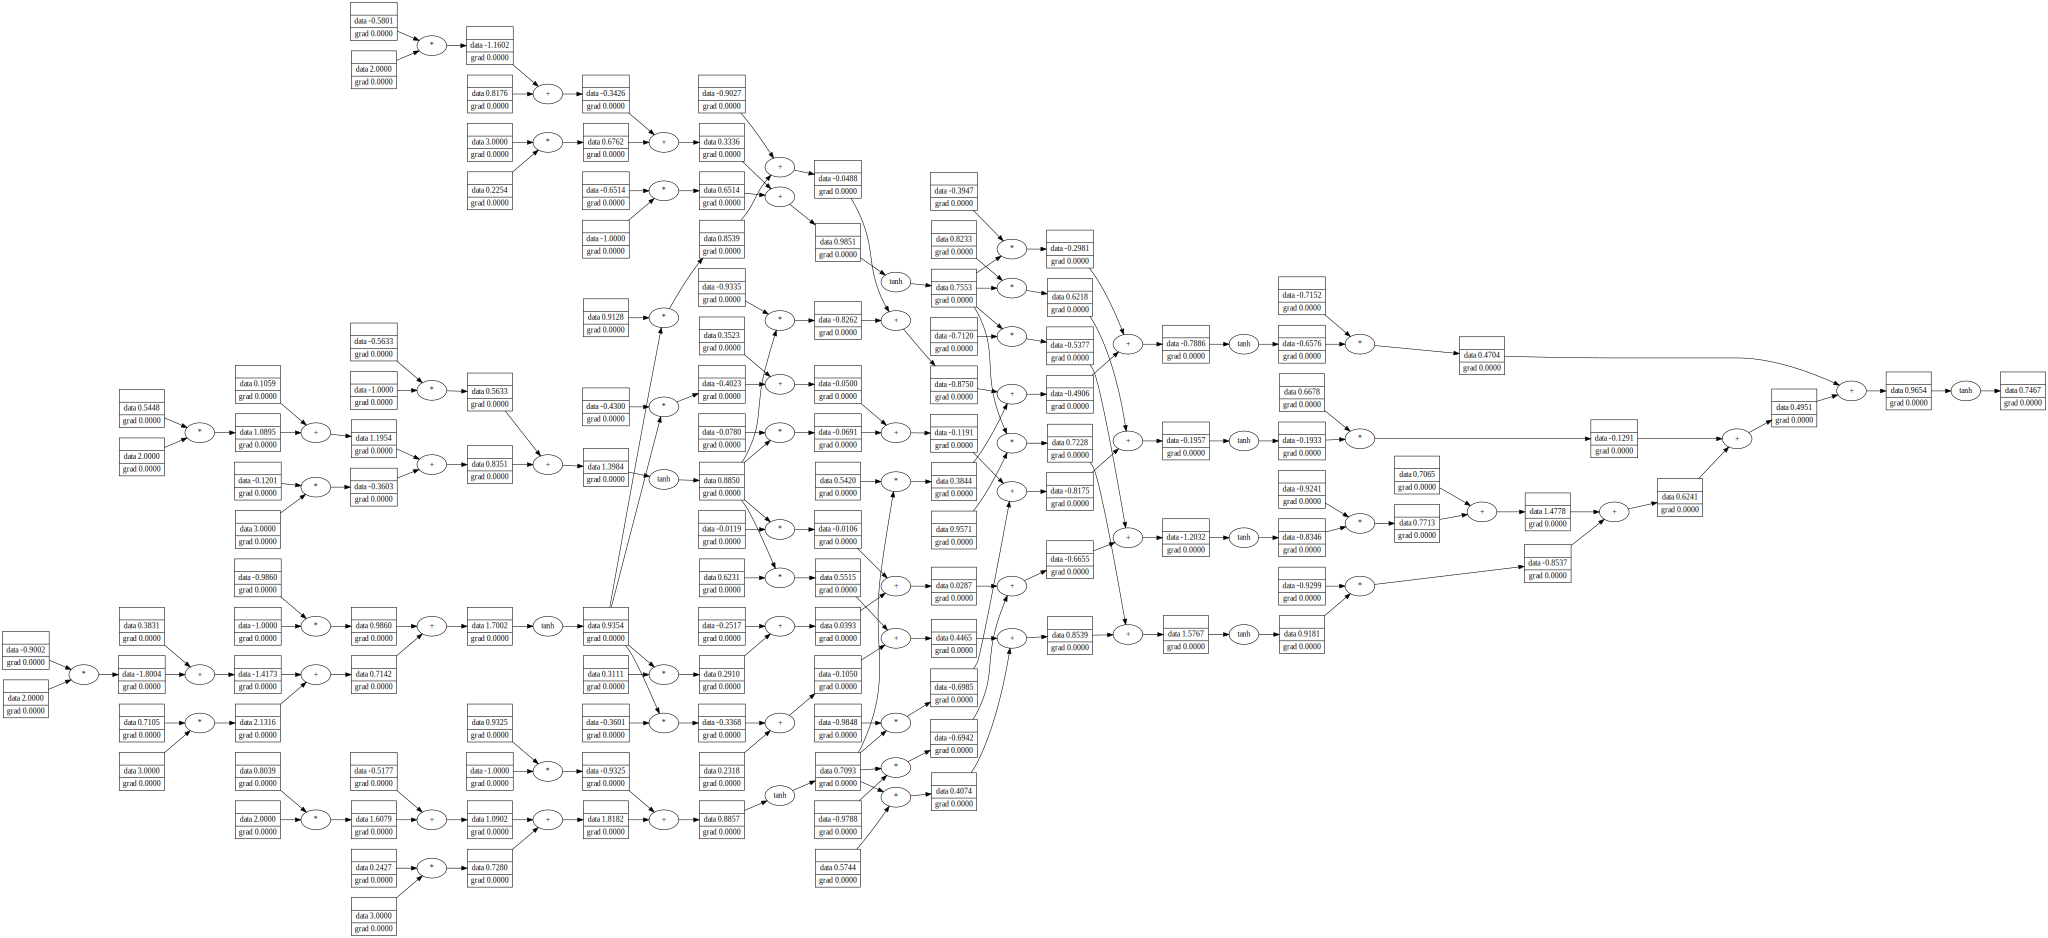

In [98]:
draw_dot(n(x))

In [99]:
xs = [
    [2.0,3.0, -1.0],
    [3.0,-1.0, 0.5],
    [0.5,1.0, 1.0],
    [1.0,1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [100]:
ypred = [n(x) for x in xs]
loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys , ypred)])
loss

(Value=6.297355527368688)

In [102]:
loss.backward()

In [103]:
n.layers[0].neurons[0].w[0].grad

-0.3101893510409847

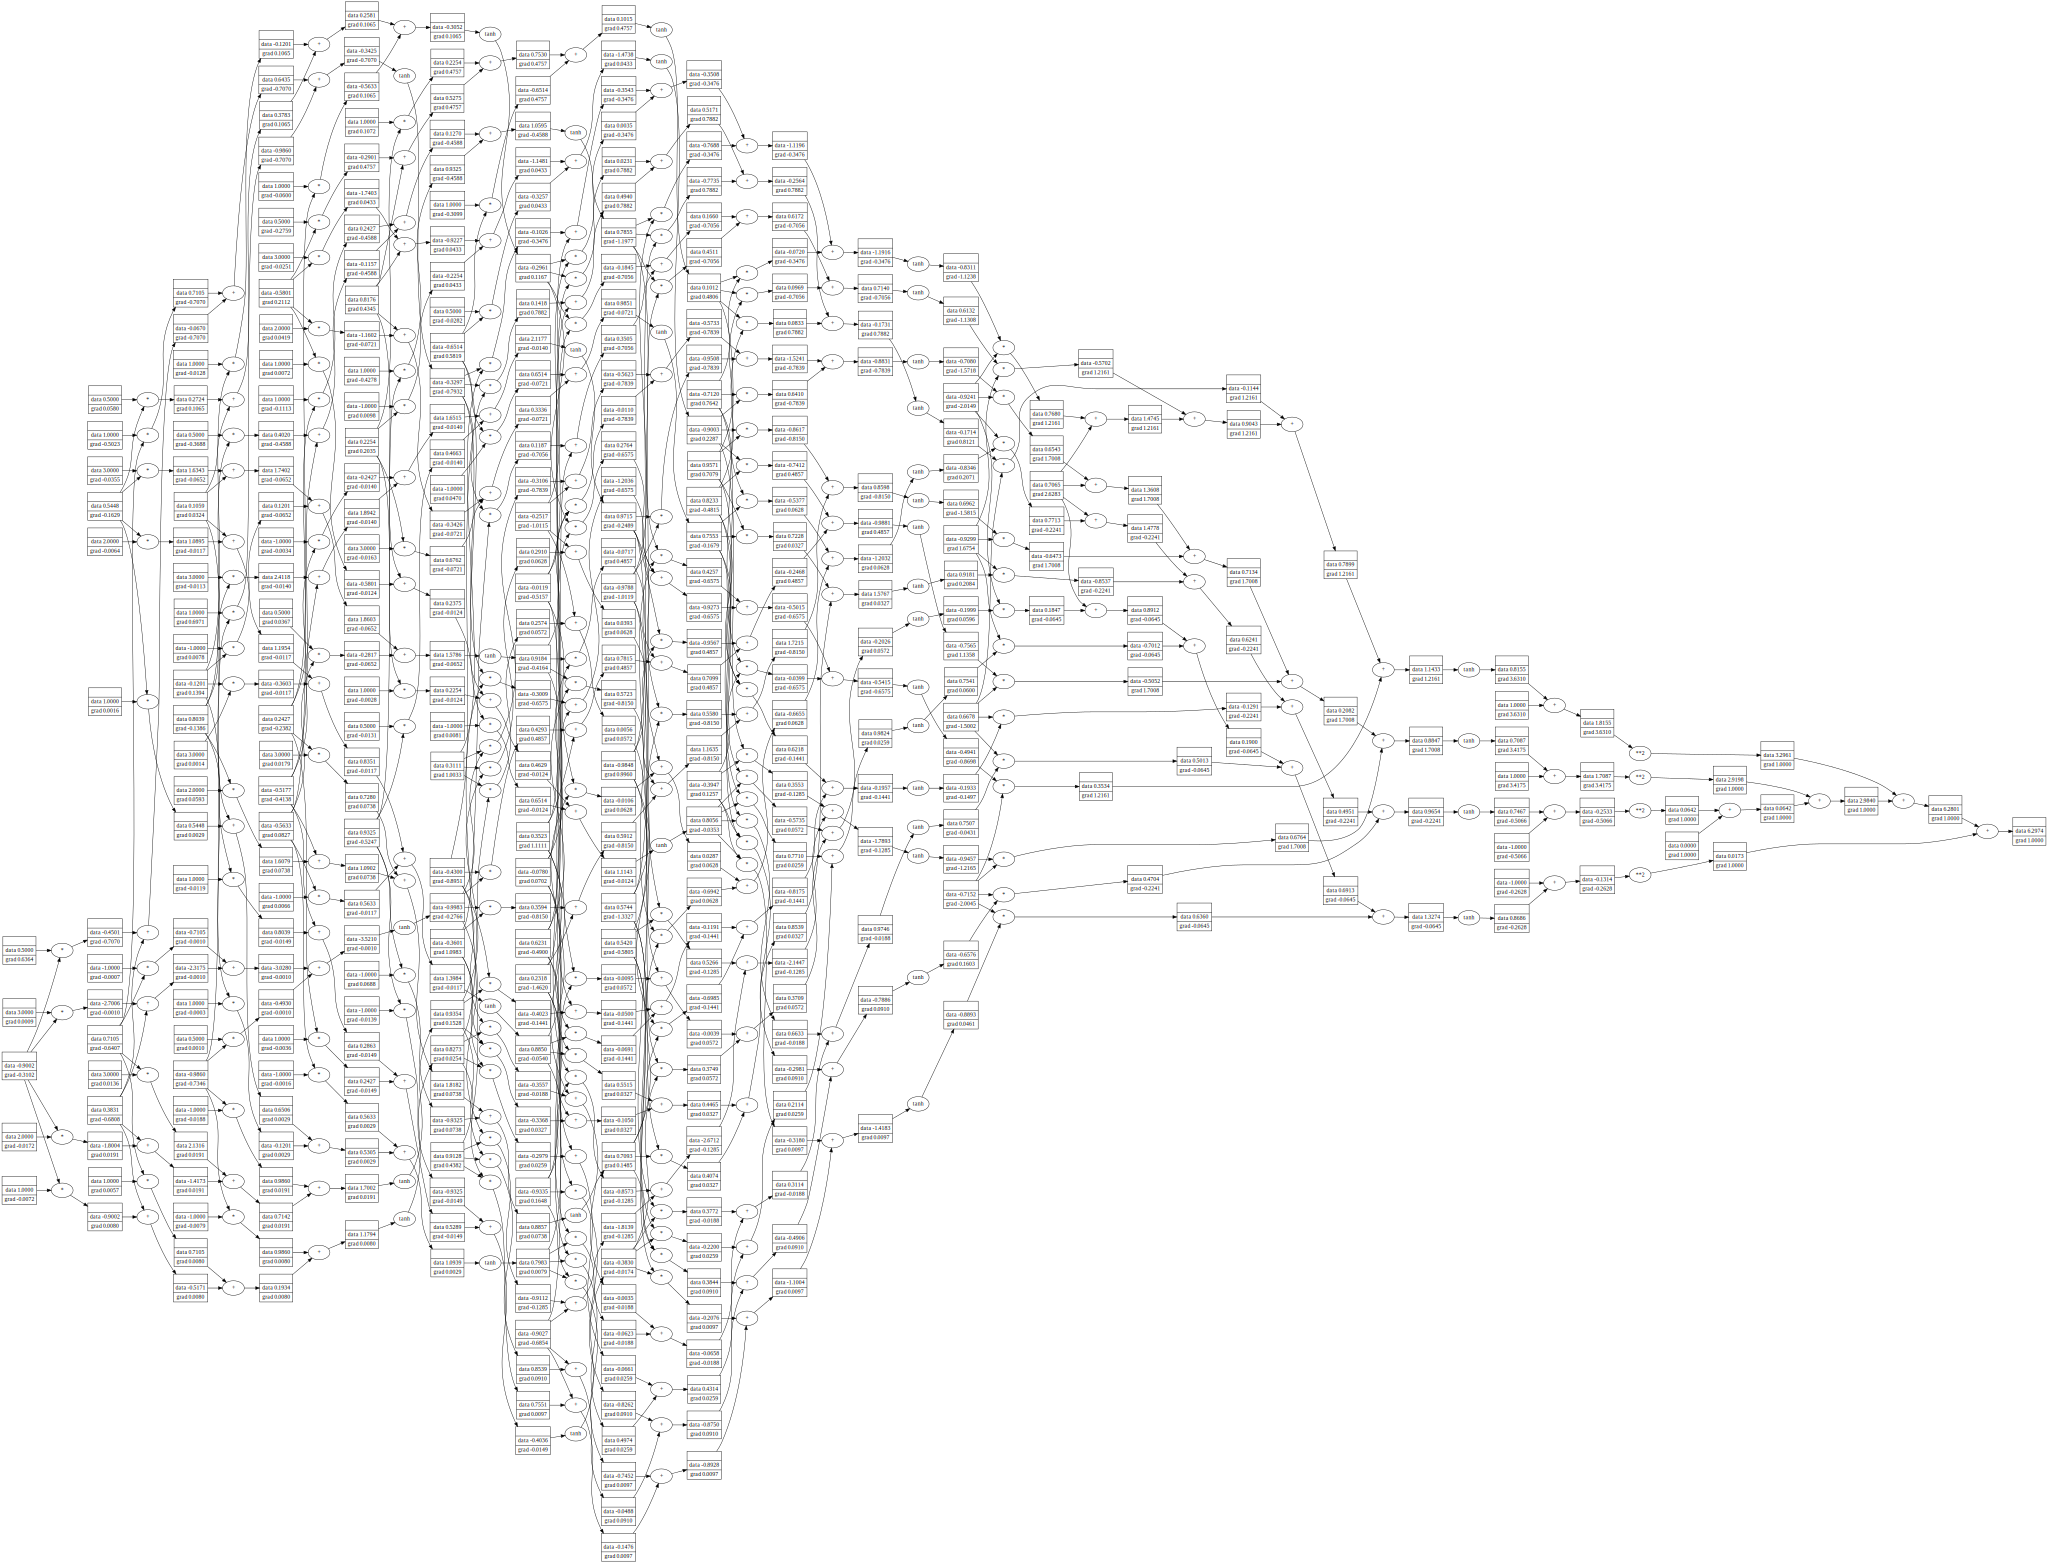

In [104]:
dot = draw_dot(loss)
dot

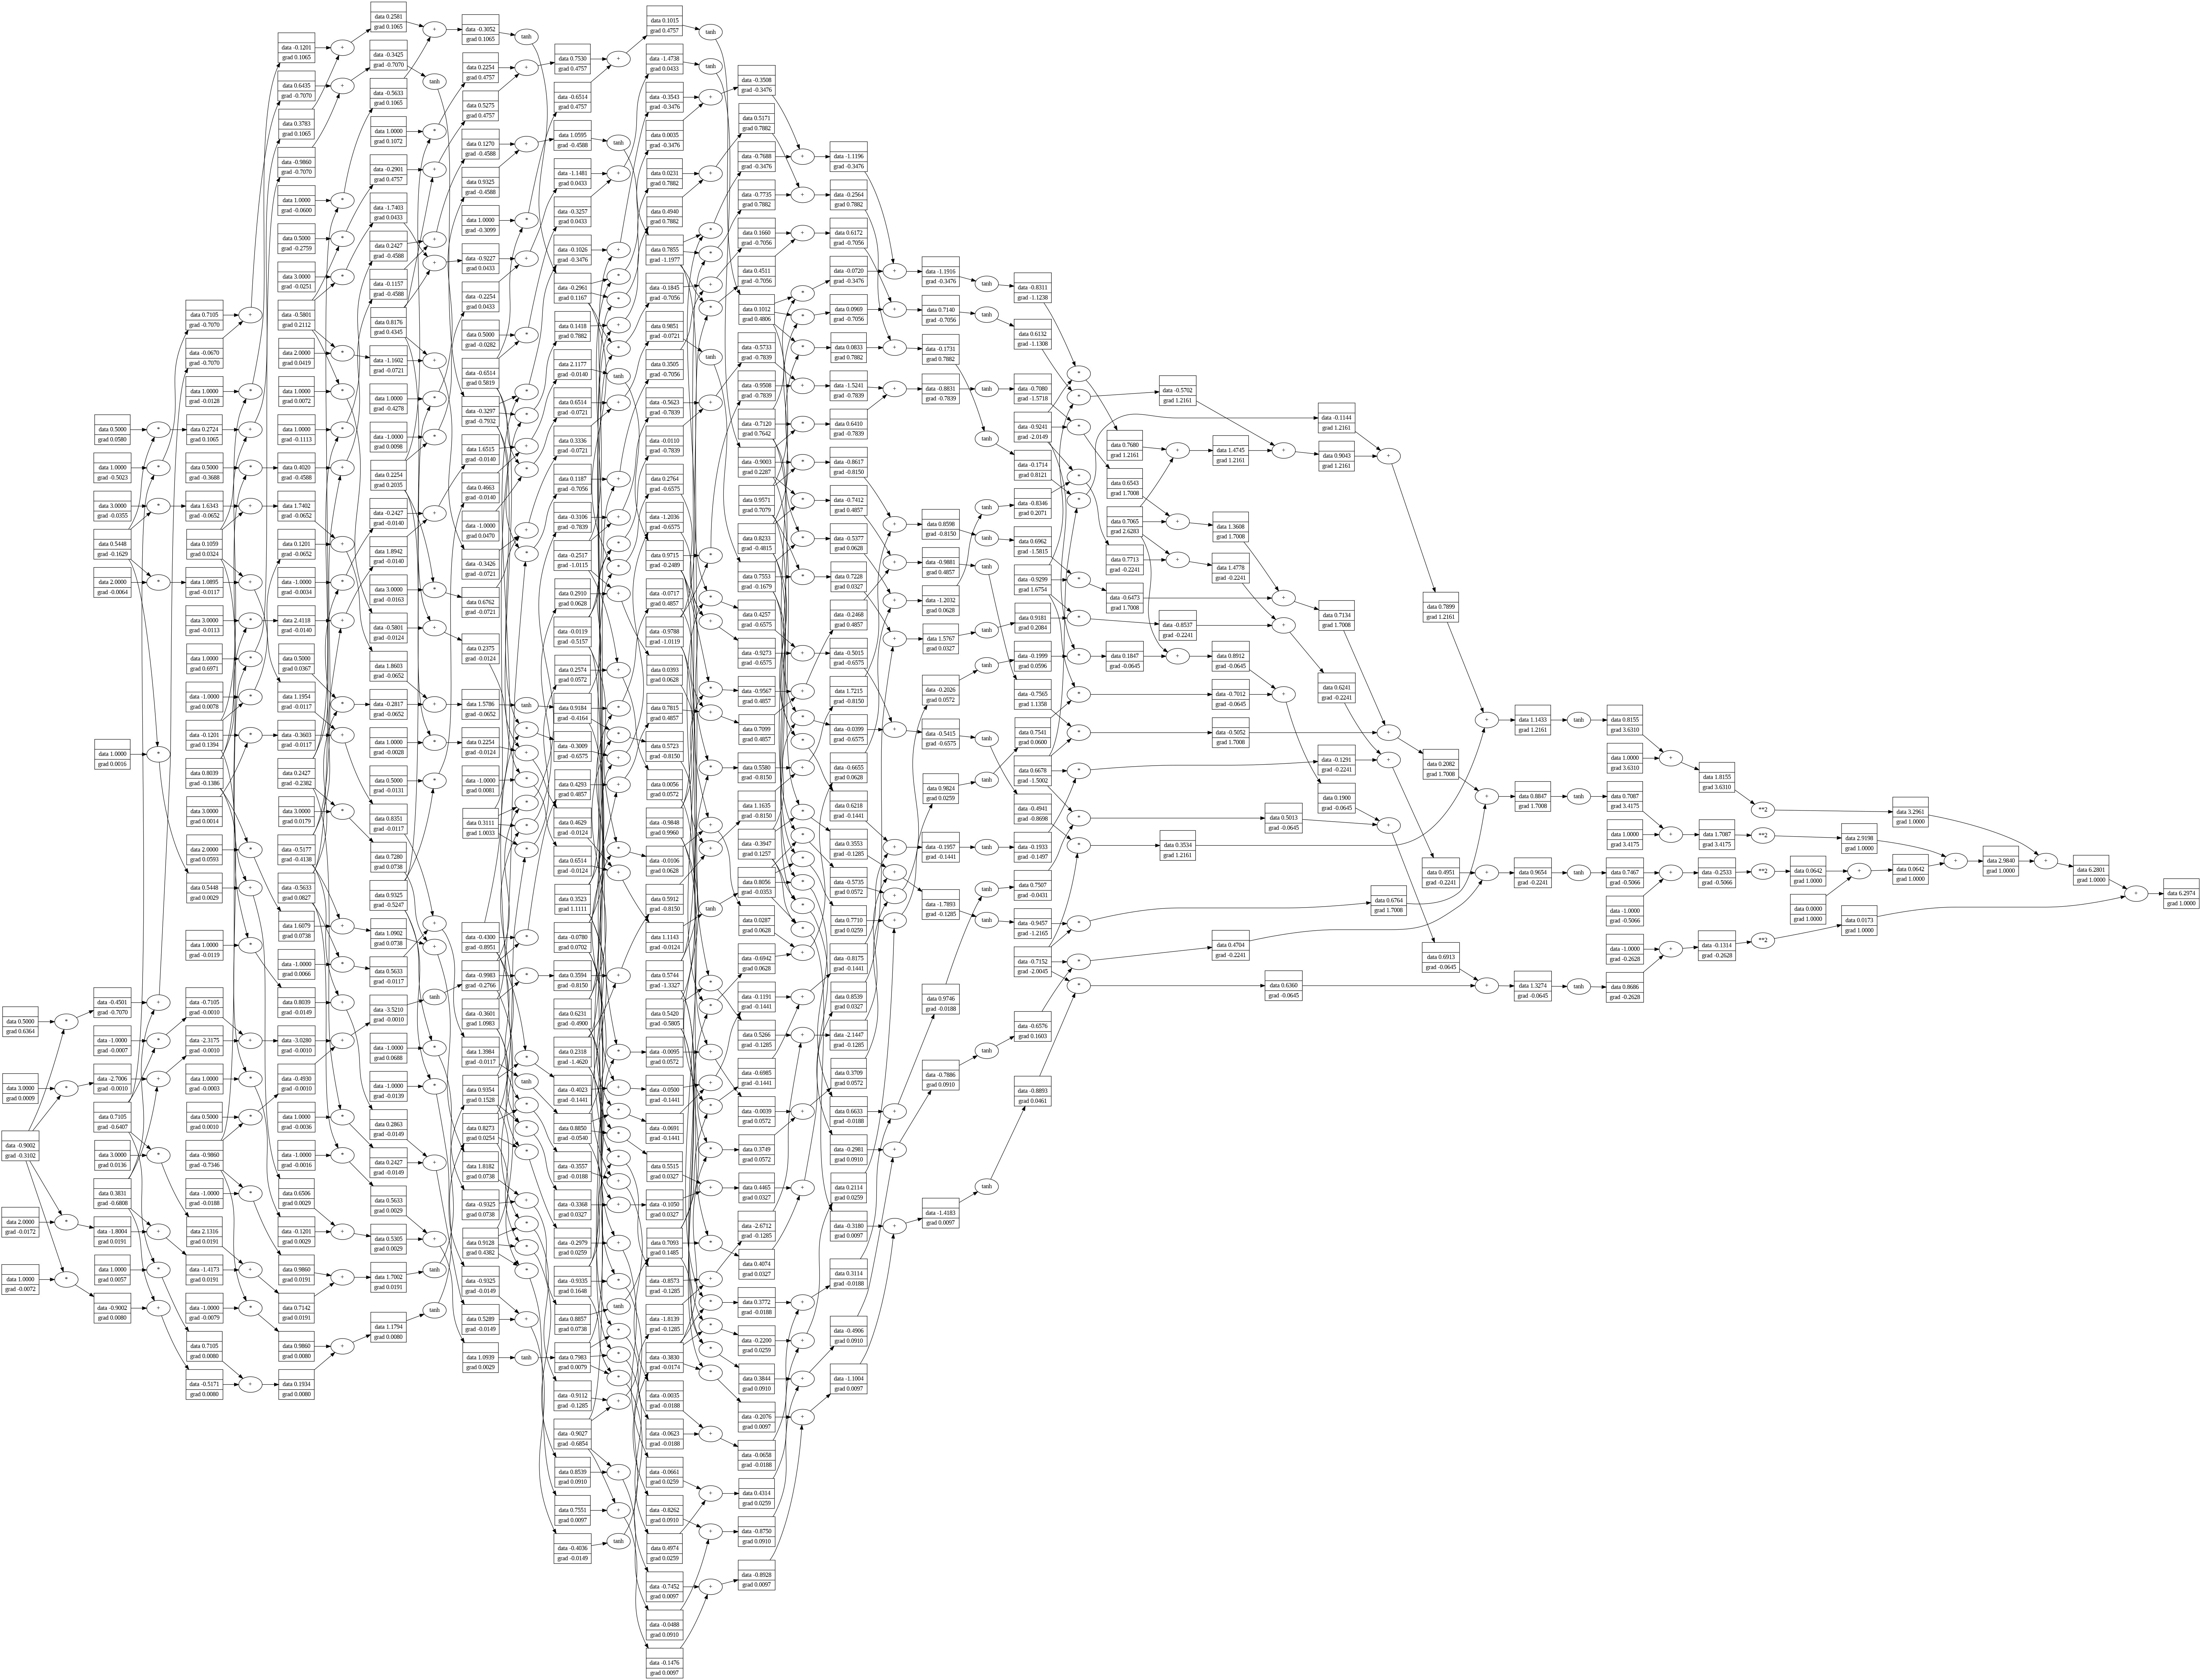

In [105]:
from IPython.display import Image, display
display(Image(filename=dot.render(format='png')))

In [106]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [107]:
ypred = [n(x) for x in xs]
loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys , ypred)])
loss

(Value=5.89997001237697)

### Training loop

In [109]:
# making training loop
for k in range(10):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys , ypred)])
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    # step
    for p in n.parameters():
        p.data += -0.05 * p.grad
    print(k, loss.data)

0 1.9731786022660054
1 1.0132082436011556
2 0.022160933055218636
3 0.032281090997416155
4 1.1320300374651133
5 0.00016315746147320214
6 0.00015018272638731532
7 0.00015468965077581714
8 0.00017291497815025532
9 0.00020607373569335674


In [110]:
ypred

[(Value=0.990347311086497),
 (Value=-0.9999758075498639),
 (Value=-0.9999761894658965),
 (Value=0.9893746444663571)]